# Using HTML Audio Element to play Audio in Notebooks

In [1]:
from __future__ import division, print_function, absolute_import

%matplotlib inline

import scipy.constants as const
import numpy as np
import scipy

from matplotlib.pyplot import plot
from scipy.io import wavfile
from IPython.core.display import HTML, display

In [7]:
# https://nbviewer.jupyter.org/github/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb

# this is a wrapper that take a filename and publish an html <audio> tag to listen to it
# 
# note that this is not needed anymore in recent version of IPython and SciPy.
import sys
if sys.version_info < (3,):
    from StringIO import StringIO as BytesIO
else:
    from io import BytesIO
import base64

def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    
    Adapted from SciPy.io.
    """
    
    buffer = BytesIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
#    return buffer.getvalue()
    # Determine file size and place it in correct
    #  position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    <div>HTML</div>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

In [3]:
try:
    from IPython.display import Audio
    def wavPlayer(data, rate):
        display(Audio(data, rate=rate))
except ImportError:
    pass


In [5]:
## some consstant for our audio file 
!pip install numpy
from numpy import sin, pi, linspace
rate = 44100 #44.1 khz
duration =2.5 # in sec

# this will give us sin with the righ amplitude to use with wav files
normedsin = lambda f,t : 2**13*sin(2*pi*f*t)

time = linspace(0,duration, num=int(rate*duration))

7040


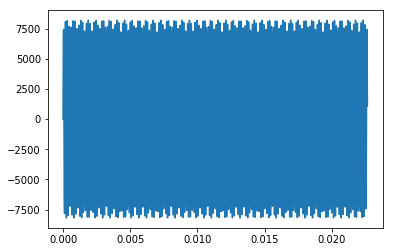

In [6]:
# define A as a 440 Hz sin function 
frequ = 440 * 16
print(frequ)
la    = lambda t : normedsin(frequ, t)

# look at it on the first 25 ms
plot(time[0:1000], la(time)[0:1000])

ampl = la(time).astype(np.int16)

# write the file on disk, and show in in a Html 5 audio player
wavPlayer(ampl, rate)

In [14]:
!pip install pydub

from pydub import AudioSegment
from pydub.playback import play

sound = AudioSegment.from_file("piano2.wav", format="wav")

# playback not possible without ffplay backend
# play(sound)

# creating milli-second-accurate snippets is super easy!
part = sound[0:10000]

print(part.dBFS)
print(part.frame_rate)
print(part.frame_count())

samples = part.get_array_of_samples()
print(samples[0:100])

-19.941352388287477
48000
302688.0
array('h', [-11, -15, 3, -3, -22, -11, 0, 0, -7, -3, -15, -15, -3, 0, 0, -3, -7, -7, -7, -11, -11, -7, -15, -11, 0, -3, -3, -3, -7, -3, -7, -7, -3, -7, -3, -11, 0, -3, -3, -7, -3, -3, -7, -7, -3, -3, -18, -11, 0, -3, -3, 0, -3, -7, -3, -7, 3, 0, -15, -7, -3, -7, -3, 0, -7, -3, -7, -7, -11, -11, 0, 0, -3, -11, -7, 0, -11, -3, -3, -11, -7, -7, 0, 0, -15, -3, -11, -11, 0, -3, -11, -18, 3, -3, 0, -3, -3, -7, -3, 0])


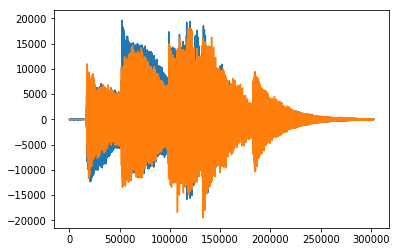

In [24]:
# look at it on the first 25 ms
plot(stereo_track[0])
plot(stereo_track[1])

In [25]:
# separate multiplexed stereo channels
num_frames = int(part.frame_count()) * 2
stereo_track = np.zeros(shape=(2, num_frames // 2))

for i in range(num_frames):
    if i % 2 == 0:
        stereo_track[0][i // 2] = samples[i]
    else:
        stereo_track[1][(i-1) // 2] = samples[i]
    

wavPlayer(stereo_track, part.frame_rate)